In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import cartopy as cy
import cartopy.crs as ccrs
from AR_occurence3550 import ar3550
from importcmip import cm245_3550
from importcmip import aod245_3550
import s3fs
xr.set_options(display_style='html')
import intake
import cftime
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display

In [3]:
ar3550

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 5475)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2035-01-01 12:00:00 ... 2049-12-31 12:00:00
Data variables:
    ivt      (lat, time, lon) bool False False False False ... False False False

In [4]:
cm245_3550

<xarray.Dataset>
Dimensions:    (member_id: 1, time: 5840, lat: 96, lon: 144, bnds: 2, plev: 8)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time       (time) object 2035-01-01 12:00:00 ... 2050-12-31 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(5840, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    clt        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1205, 96, 144), meta=np.ndarray>
    hus        (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 80, 8, 96, 144), meta=np.ndarray>
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 190, 96, 144), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 305, 96, 144), meta=np.ndarray>
    va         (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 136, 8, 96, 144), meta=np.ndarray>
Attributes: (12/54)
    forcing_index:             1
    title:                     NorESM2-LM output prepared for CMIP6
    external_variables:        areacella
    variable_id:               va
    table_id:                  day
    grid:                      finite-volume grid with 1.9x2.5 degree lat/lon...
    ...                        ...
    intake_esm_varname:        clt\nhus\npr\ntas\nva
    data_specs_version:        01.00.31
    experiment:                update of RCP4.5 based on SSP2
    initialization_index:      1
    mip_era:                   CMIP6
    intake_esm_dataset_key:    ScenarioMIP.NCC.NorESM2-LM.ssp245.day.gn

In [132]:
cm245_3550.plev

<xarray.DataArray 'plev' (plev: 8)>
array([100000.,  85000.,  70000.,  50000.,  25000.,  10000.,   5000.,   1000.])
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
    height   float64 ...
Attributes:
    axis:           Z
    long_name:      pressure
    positive:       down
    standard_name:  air_pressure
    units:          Pa

In [13]:
aod245_3550

<xarray.Dataset>
Dimensions:     (time: 5840, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time        (time) object 2035-01-01 12:00:00 ... 2050-12-31 12:00:00
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    wavelength  float64 550.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object dask.array<chunksize=(2190, 2), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(2190, 96, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(2190, 144, 2), meta=np.ndarray>
    od550aer    (time, lat, lon) float32 dask.array<chunksize=(2190, 96, 144), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP
    branch_method:             Hybrid-restart from year 2015-01-01 of historical
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     60225.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               od550aer
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/95a1155d-3741-472f-b7ef-3487221d4692

In [19]:
# merge datasets
d245_3550 = cm245_3550.merge(aod245_3550.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))

arc = d245_3550.sel(lat = slice(50,90))
ant =d245_3550.sel(lat = slice(-90,-50))

<xarray.Dataset>
Dimensions:     (member_id: 1, time: 5840, lat: 96, lon: 144, bnds: 2, plev: 8)
Coordinates:
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time        (time) object 2035-01-01 12:00:00 ... 2050-12-31 12:00:00
    time_bnds   (time, bnds) object dask.array<chunksize=(5840, 2), meta=np.ndarray>
  * member_id   (member_id) <U8 'r1i1p1f1'
  * plev        (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
    height      float64 ...
    wavelength  float64 550.0
Dimensions without coordinates: bnds
Data variables:
    clt         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1205, 96, 144), meta=np.ndarray>
    hus         (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 80, 8, 96, 144), meta=np.ndarray>
    pr          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 190, 96, 144), meta=np.ndarray>
    tas         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 305, 96, 144), meta=np.ndarray>
    va          (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 136, 8, 96, 144), meta=np.ndarray>
    od550aer    (time, lat, lon) float32 dask.array<chunksize=(2190, 96, 144), meta=np.ndarray>
Attributes: (12/54)
    forcing_index:             1
    title:                     NorESM2-LM output prepared for CMIP6
    external_variables:        areacella
    variable_id:               va
    table_id:                  day
    grid:                      finite-volume grid with 1.9x2.5 degree lat/lon...
    ...                        ...
    intake_esm_varname:        clt\nhus\npr\ntas\nva
    data_specs_version:        01.00.31
    experiment:                update of RCP4.5 based on SSP2
    initialization_index:      1
    mip_era:                   CMIP6
    intake_esm_dataset_key:    ScenarioMIP.NCC.NorESM2-LM.ssp245.day.gn

In [20]:
# mask data within and out of atmospheric rivers
marc = arc.where(ar3550['ivt'] == True)
mant = ant.where(ar3550['ivt'] == True)
amarc = arc.where(ar3550['ivt'] == False)
amant = ant.where(ar3550['ivt'] == False)

## Arctic

In [6]:
# for frequency plots slice for plev >25000 and integrate over plev
mpl =marc.sel(plev=slice(100000, 25000))
pl =amarc.sel(plev=slice(100000, 25000)).where(arc['va'] > 0)

# wind
mplva =-1*mpl['va'].integrate('plev')
plva =-1*pl['va'].integrate('plev')

# humidity
mplh =-1*mpl['hus'].integrate('plev')
plh =-1*pl['hus'].integrate('plev')


In [7]:
mv = mplva.values.flatten()
mv = mv[~np.isnan(mv)]
v = plva.values.flatten()
v= v[~np.isnan(v)]
mh = mplh.values.flatten()
mh = mh[~np.isnan(mh)]
h = plh.values.flatten()
h = h[~np.isnan(h)]
mcc = pl['clt'].values.flatten()
mcc = mcc[~np.isnan(mcc)]
cc = mpl['clt'].values.flatten()
cc = cc[~np.isnan(cc)]
mt = mpl['tas'].values.flatten()
mt = mt[~np.isnan(mt)]
t = pl['tas'].values.flatten()
t = t[~np.isnan(t)]
ma = mpl['od550aer'].values.flatten()
ma = ma[~np.isnan(ma)]
a = pl['od550aer'].values.flatten()
a = a[~np.isnan(a)]
mp = mpl['pr'].values.flatten()
mp = mp[~np.isnan(mp)]
p = pl['pr'].values.flatten()
p = p[~np.isnan(p)]

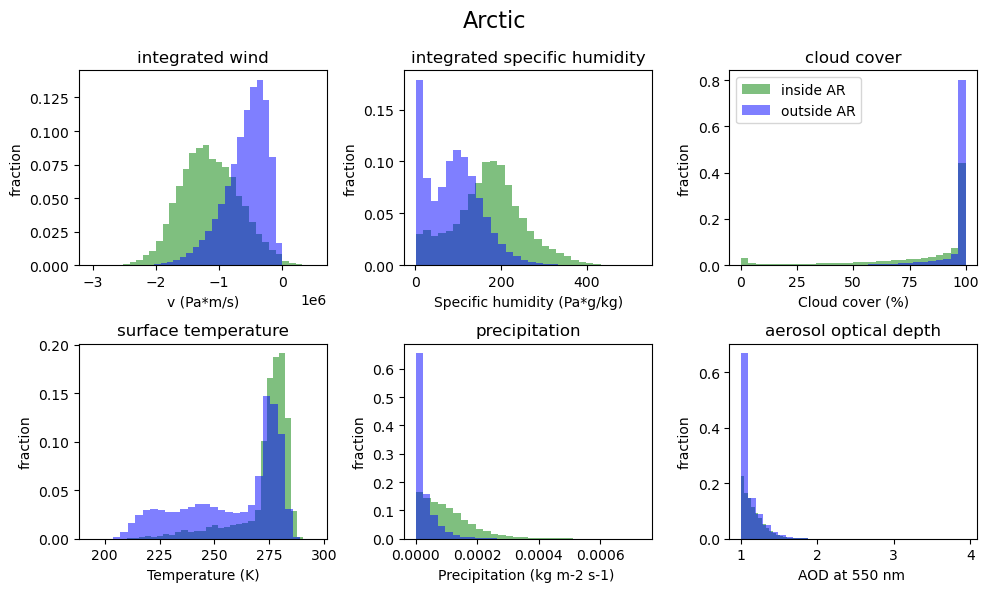

In [25]:
fig, axs = plt.subplots(2,3, figsize=(10,6))
axs = axs.flatten()
fig.suptitle('Arctic', fontsize=16)
axs[0].hist(mv, weights = np.zeros_like(mv)+1./mv.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[0].hist(v, weights = np.zeros_like(v)+1./v.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[1].hist(mh, weights = np.zeros_like(mh)+1./mh.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[1].hist(h, weights = np.zeros_like(h)+1./h.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[2].hist(mcc, weights = np.zeros_like(mcc)+1./mcc.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[2].hist(cc,  weights = np.zeros_like(cc)+1./cc.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[3].hist(mt, weights = np.zeros_like(mt)+1./mt.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[3].hist(t, weights = np.zeros_like(t)+1./t.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[4].hist(mp, weights = np.zeros_like(mp)+1./mp.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[4].hist(p, weights = np.zeros_like(p)+1./p.size,
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[5].hist(ma, weights = np.zeros_like(ma)+1./ma.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[5].hist(a, weights = np.zeros_like(a)+1./a.size,
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[0].set_title('integrated wind')
axs[0].set(ylabel = 'fraction', xlabel = 'v (Pa*m/s)')
axs[1].set_title('integrated specific humidity')
axs[1].set(ylabel = 'fraction', xlabel = 'Specific humidity (Pa*g/kg)')
axs[2].set_title('cloud cover')
axs[2].legend()
axs[2].set(ylabel = 'fraction', xlabel = 'Cloud cover (%)')
axs[3].set_title('surface temperature')
axs[3].set(ylabel = 'fraction', xlabel = 'Temperature (K)')
axs[4].set_title('precipitation')
axs[4].set(ylabel = 'fraction', xlabel = 'Precipitation (kg m-2 s-1) ')
axs[5].set_title('aerosol optical depth')
axs[5].set(ylabel = 'fraction', xlabel = 'AOD at 550 nm ')
plt.tight_layout()
    

## Antarctic

In [21]:
# for frequency plots slice for plev >25000 and integrate over plev
mpl =mant.sel(plev=slice(100000, 25000))
pl =amant.sel(plev=slice(100000, 25000)).where(ant['va'] < 0)

# wind
mplva =-1*mpl['va'].integrate('plev')
plva =-1*pl['va'].integrate('plev')

# humidity
mplh =-1*mpl['hus'].integrate('plev')
plh =-1*pl['hus'].integrate('plev')


In [22]:
mv = mplva.values.flatten()
mv = mv[~np.isnan(mv)]
v = plva.values.flatten()
v= v[~np.isnan(v)]
mh = mplh.values.flatten()
mh = mh[~np.isnan(mh)]
h = plh.values.flatten()
h = h[~np.isnan(h)]
mcc = pl['clt'].values.flatten()
mcc = mcc[~np.isnan(mcc)]
cc = mpl['clt'].values.flatten()
cc = cc[~np.isnan(cc)]
mt = mpl['tas'].values.flatten()
mt = mt[~np.isnan(mt)]
t = pl['tas'].values.flatten()
t = t[~np.isnan(t)]
ma = mpl['od550aer'].values.flatten()
ma = ma[~np.isnan(ma)]
a = pl['od550aer'].values.flatten()
a = a[~np.isnan(a)]
mp = mpl['pr'].values.flatten()
mp = mp[~np.isnan(mp)]
p = pl['pr'].values.flatten()
p = p[~np.isnan(p)]

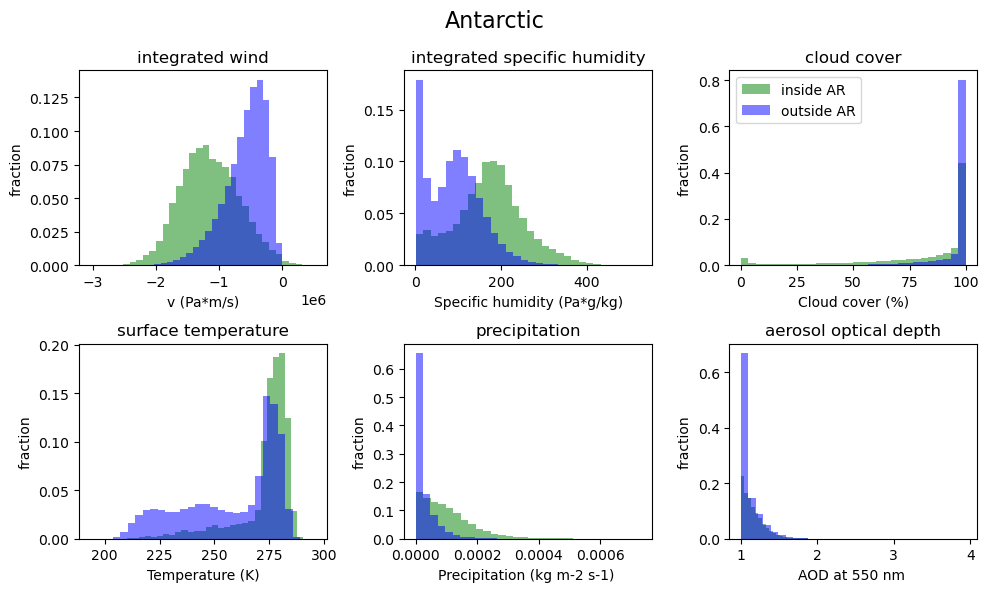

In [24]:
fig, axs = plt.subplots(2,3, figsize=(10,6))
fig.suptitle('Antarctic', fontsize=16)
axs = axs.flatten()
axs[0].hist(mv, weights = np.zeros_like(mv)+1./mv.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[0].hist(v, weights = np.zeros_like(v)+1./v.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[1].hist(mh, weights = np.zeros_like(mh)+1./mh.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[1].hist(h, weights = np.zeros_like(h)+1./h.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[2].hist(mcc, weights = np.zeros_like(mcc)+1./mcc.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[2].hist(cc,  weights = np.zeros_like(cc)+1./cc.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[3].hist(mt, weights = np.zeros_like(mt)+1./mt.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[3].hist(t, weights = np.zeros_like(t)+1./t.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[4].hist(mp, weights = np.zeros_like(mp)+1./mp.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[4].hist(p, weights = np.zeros_like(p)+1./p.size,
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[5].hist(ma, weights = np.zeros_like(ma)+1./ma.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[5].hist(a, weights = np.zeros_like(a)+1./a.size,
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[0].set_title('integrated wind')
axs[0].set(ylabel = 'fraction', xlabel = 'v (Pa*m/s)')
axs[1].set_title('integrated specific humidity')
axs[1].set(ylabel = 'fraction', xlabel = 'Specific humidity (Pa*g/kg)')
axs[2].set_title('cloud cover')
axs[2].set(ylabel = 'fraction', xlabel = 'Cloud cover (%)')
axs[2].legend()
axs[3].set_title('surface temperature')
axs[3].set(ylabel = 'fraction', xlabel = 'Temperature (K)')
axs[4].set_title('precipitation')
axs[4].set(ylabel = 'fraction', xlabel = 'Precipitation (kg m-2 s-1) ')
axs[5].set_title('aerosol optical depth')
axs[5].set(ylabel = 'fraction', xlabel = 'AOD at 550 nm ')
plt.tight_layout()